In [1]:
import torch
import os
from os import walk
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='white', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import datetime, os
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from datetime import timedelta

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=60):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float().to(device)
        self.X = torch.tensor(dataframe[features].values).float().to(device)
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]
    
class LSTM_2(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of (receivers) features from above
        self.hidden_units = hidden_units
        self.num_layers = 2
        self.lstm = nn.LSTM(input_size=num_sensors, hidden_size=hidden_units, batch_first=True,
            num_layers=self.num_layers)
        self.fc1 = nn.Linear(in_features=self.hidden_units, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_sensors)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device)
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.fc1(hn[-1])
        out = self.fc2(out)
        return out

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    plot_loss.append(avg_loss)
    print(f"Train loss: {avg_loss}")

def val_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    plot_tloss.append(avg_loss)
    print(f"Val loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X).to(device)
            output = torch.cat((output, y_star), 0)
    return output

In [2]:
######### Parameters ###########
learning_rate = 1e-3
num_hidden_units = 256
batch_size = 64
sequence_length = 60 # 60 * 5sec intervals, 5 minutes
count = 0
from torch.optim.lr_scheduler import MultiStepLR


DYNGC210M_merged.csv


<ipython-input-3-51efc6176eb1>:25: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_val = df.loc[val_start:val_end].copy()


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------
Train loss: 0.20273603014748573
Val loss: 1.709892271007499
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.17824012655320812
Val loss: 0.5570190357038481
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 2
---------
Train loss: 0.12899945344294286
Val loss: 0.4646606060600131
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 3
---------
Train loss: 0.08448110168017604
Val loss: 0.0647389088956696
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 4
---------
Train loss: 0.08615146148004978
Val loss: 0.11630028597981253
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5
---------
Train loss: 0.0784965891850576
Val loss: 0.08278220846651997
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.07900136065117738
Val loss: 0.06266912276869571
Adjusting learning rate of group 0 to 1.00

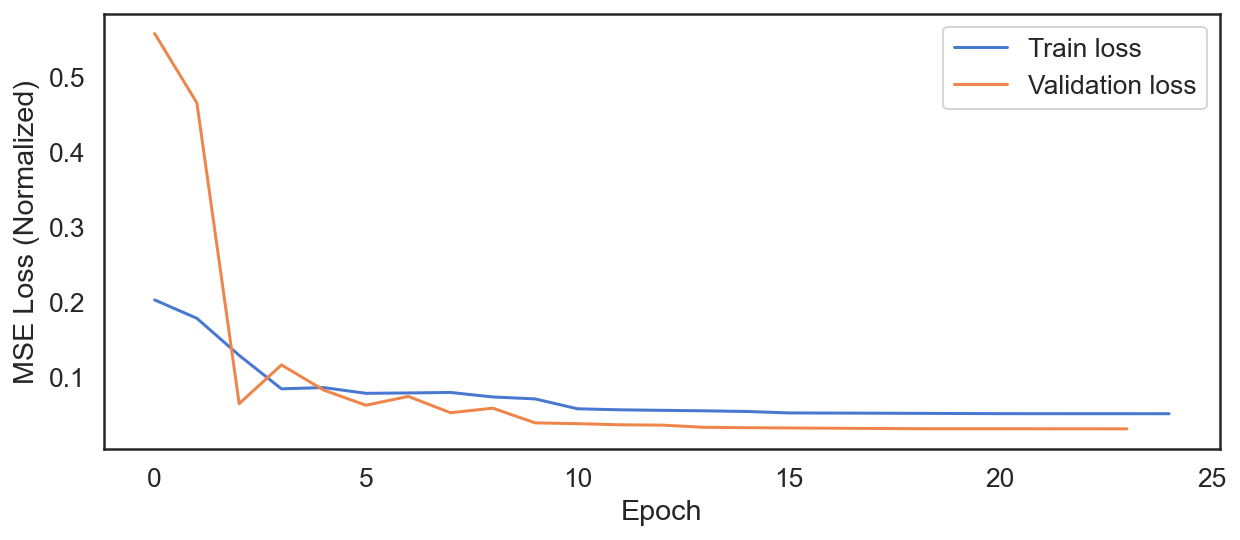

DYNGE203_merged.csv


<ipython-input-3-51efc6176eb1>:25: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_val = df.loc[val_start:val_end].copy()


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------
Train loss: 0.19783869980954066
Val loss: 0.006636384734109162
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.16134386598208575
Val loss: 0.00666427877603177
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2
---------
Train loss: 0.1454110584990229
Val loss: 0.006270117007237541
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 3
---------
Train loss: 0.13699063862663802
Val loss: 0.006288947971091621
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4
---------
Train loss: 0.12464225697405618
Val loss: 0.006924801877265121
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5
---------
Train loss: 0.11740284083335228
Val loss: 0.007801045827370222
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.10365146884194325
Val loss: 0.011346707204536203
Adjusting learning rate of group 0 to 1.0000e-03.

Epoc

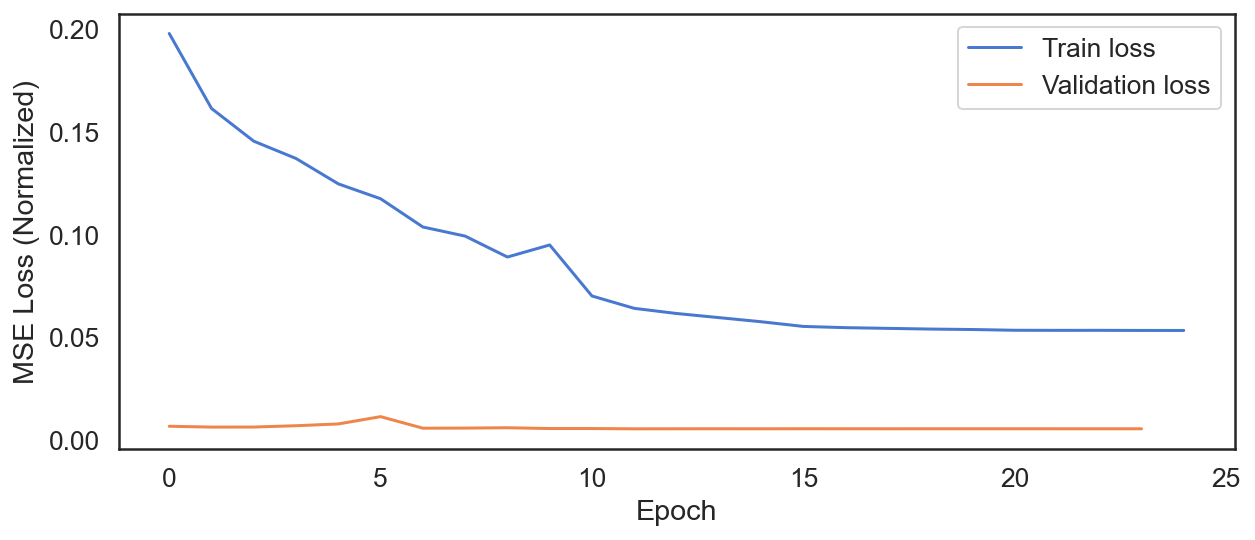

DYNGGPS50_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------


<ipython-input-3-51efc6176eb1>:25: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_val = df.loc[val_start:val_end].copy()


Train loss: 0.1116693969264745
Val loss: 0.026237585204891372
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.10284428377838715
Val loss: 0.021575172461678078
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 2
---------
Train loss: 0.09832062622125275
Val loss: 0.022054763449301577
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3
---------
Train loss: 0.09831157043626701
Val loss: 0.021166585944592954
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 4
---------
Train loss: 0.09552023476933089
Val loss: 0.020497523920515376
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 5
---------
Train loss: 0.09486626609019032
Val loss: 0.02149356111381067
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.0951046127687758
Val loss: 0.02030388349565222
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 7
---------
Train loss: 0.093757

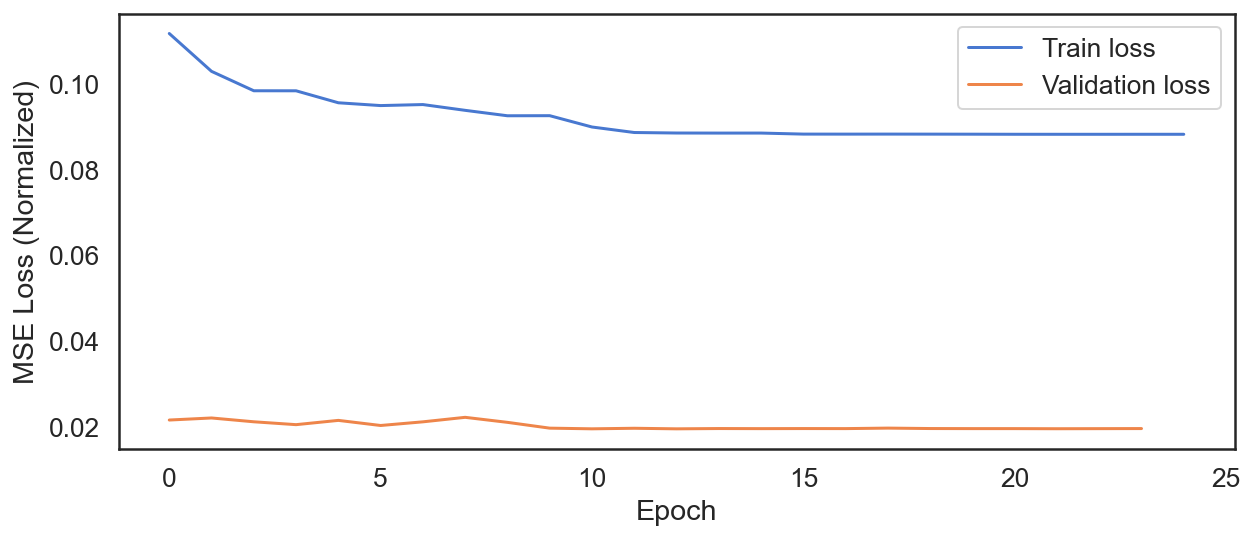

DYNGR856_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------


<ipython-input-3-51efc6176eb1>:25: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_val = df.loc[val_start:val_end].copy()


Train loss: 0.24218779354992673
Val loss: 0.11517504717635745
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.22451982498758702
Val loss: 0.11355588918853454
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 2
---------
Train loss: 0.22605616079353405
Val loss: 0.12439048209038826
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3
---------
Train loss: 0.21998548588683547
Val loss: 0.11231821191329446
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 4
---------
Train loss: 0.2185916664820941
Val loss: 0.11324361504592415
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5
---------
Train loss: 0.2154823394339915
Val loss: 0.11386911823527121
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.21106786817351558
Val loss: 0.11834381335538349
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7
---------
Train loss: 0.20885812924354089
Val loss: 0.11240

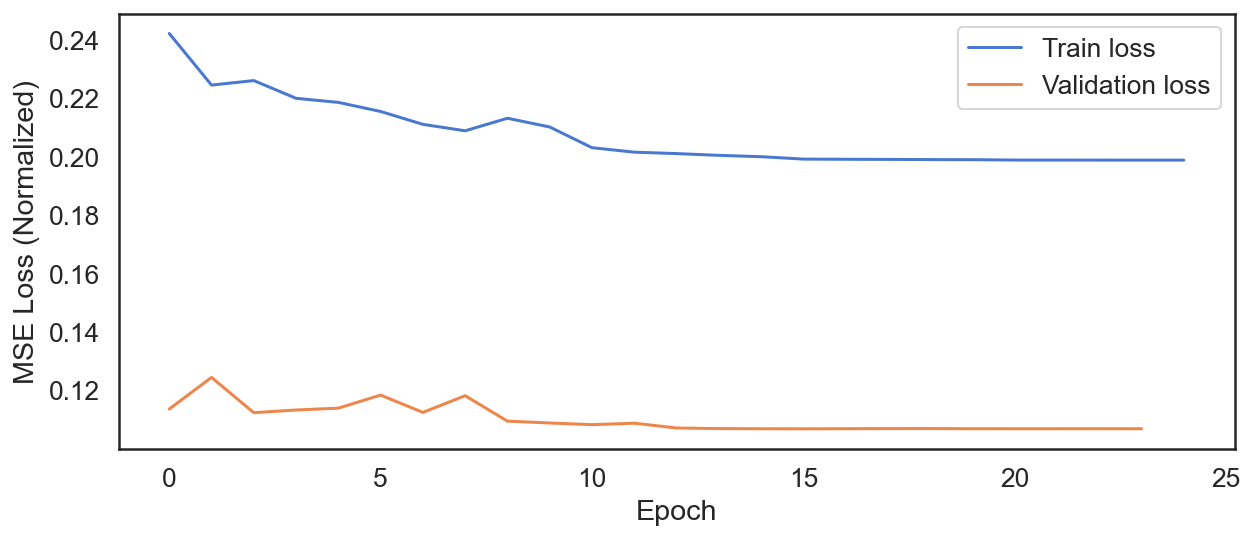

GRACC201M_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------


<ipython-input-3-51efc6176eb1>:25: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_val = df.loc[val_start:val_end].copy()


Train loss: 0.3242507890258965
Val loss: 0.9968124206850376
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.333876694280066
Val loss: 0.8993243610743588
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 2
---------
Train loss: 0.3151590557618622
Val loss: 1.2569672076282212
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3
---------
Train loss: 0.3121704007619828
Val loss: 0.808476500734097
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 4
---------
Train loss: 0.29301955572737937
Val loss: 0.7779071245902761
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 5
---------
Train loss: 0.2967951118972218
Val loss: 0.9223791170134655
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.3052382647036983
Val loss: 0.6990146198807154
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 7
---------
Train loss: 0.2987987337849642
Val los

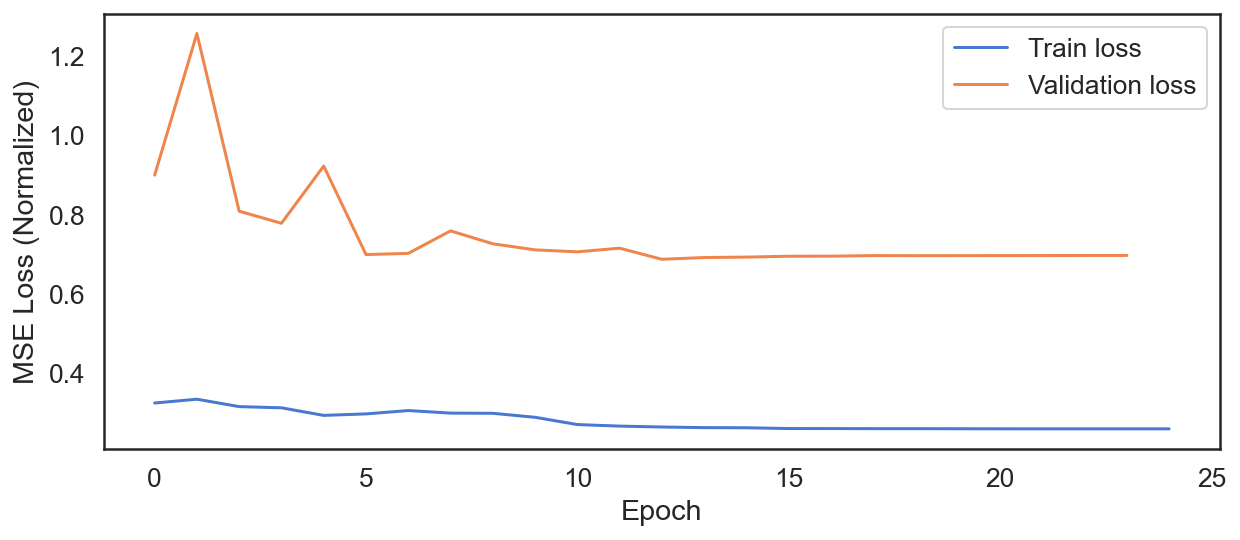

GRACE203_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------


<ipython-input-3-51efc6176eb1>:25: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_val = df.loc[val_start:val_end].copy()


Train loss: 0.24368619385769072
Val loss: 8.653435725905334
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.20634752536887221
Val loss: 8.69225868789649
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2
---------
Train loss: 0.21095219149100655
Val loss: 4.617239288912423
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 3
---------
Train loss: 0.19686413547591505
Val loss: 5.799805584601884
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4
---------
Train loss: 0.18469357802843978
Val loss: 7.625880773807334
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5
---------
Train loss: 0.18411252625054095
Val loss: 5.797111450079728
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.1801578979966899
Val loss: 6.636551283526506
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7
---------
Train loss: 0.1760914563523802
Val loss: 6.033820845636544
Adjusting learni

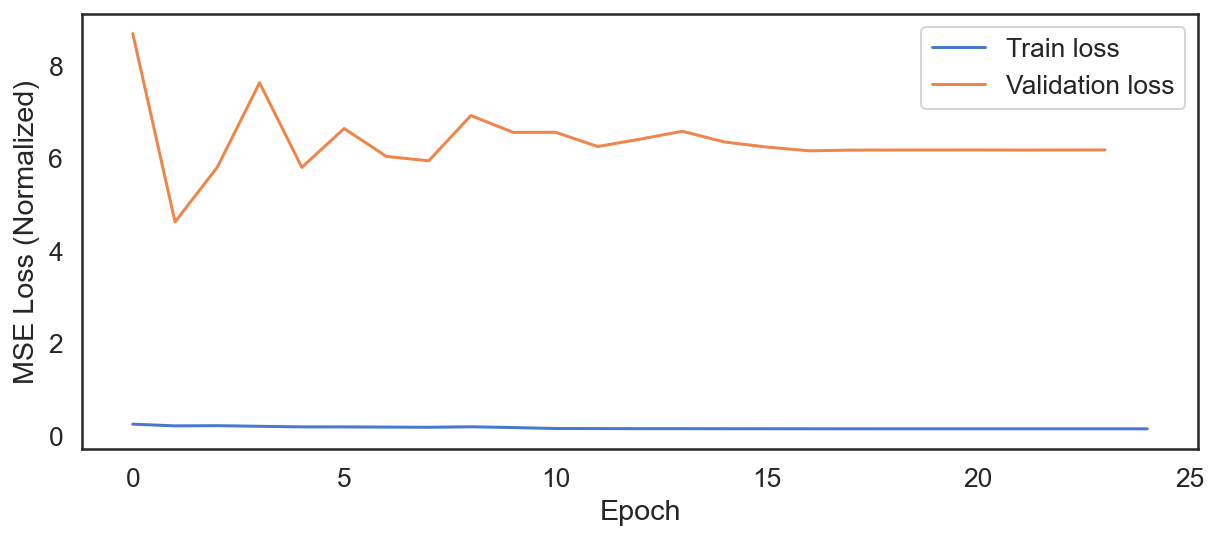

GRACGPS50_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------


<ipython-input-3-51efc6176eb1>:25: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_val = df.loc[val_start:val_end].copy()


Train loss: 0.18444188196160172
Val loss: 0.007559413225035029
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.128998655387208
Val loss: 0.010111248341358722
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2
---------
Train loss: 0.11278444410797775
Val loss: 0.008263288557228231
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3
---------
Train loss: 0.0822446693424591
Val loss: 0.0032760167470010783
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 4
---------
Train loss: 0.08640865760471965
Val loss: 0.004647177528376449
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5
---------
Train loss: 0.06713418985157699
Val loss: 0.0032646248567741857
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 6
---------
Train loss: 0.055801282223926496
Val loss: 0.003707318876440858
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7
---------
Train loss: 0.055780037229756683
Val los

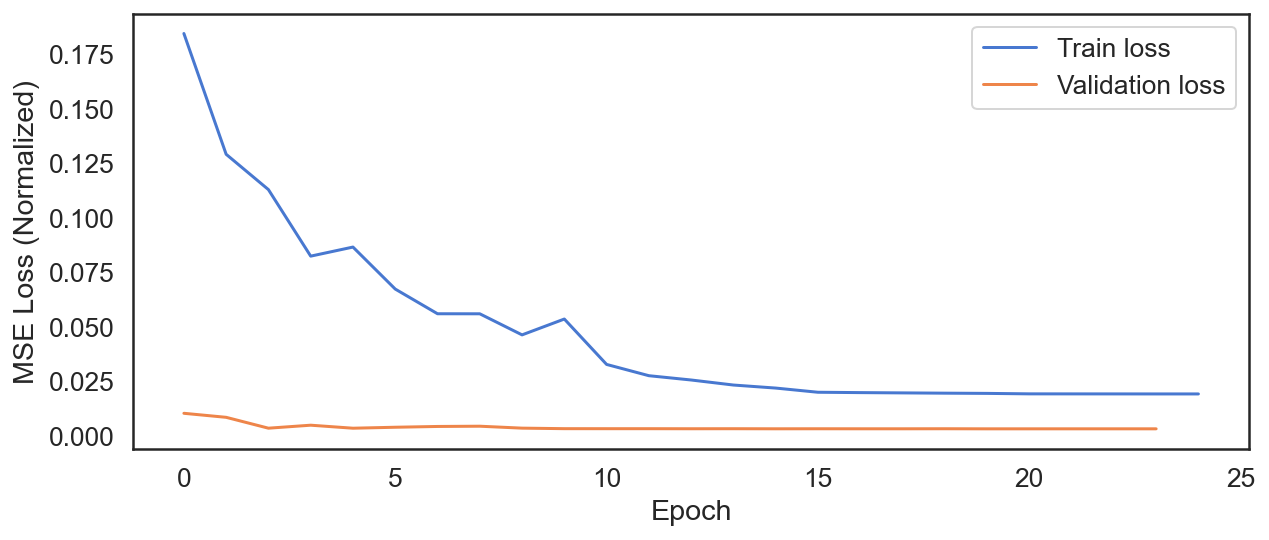

GRACR856_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------


<ipython-input-3-51efc6176eb1>:25: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_val = df.loc[val_start:val_end].copy()


Train loss: 0.17039298795035085
Val loss: 0.7180673829987442
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.15509722593047623
Val loss: 0.6747779228196592
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 2
---------
Train loss: 0.15573839873014994
Val loss: 0.753323302576293
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3
---------
Train loss: 0.14993447170268961
Val loss: 0.766604212010186
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4
---------
Train loss: 0.14644177133817332
Val loss: 0.6703489282693006
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 5
---------
Train loss: 0.1431489538487062
Val loss: 0.5926133267449264
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 6
---------
Train loss: 0.13867889400458164
Val loss: 0.7825212840904381
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7
---------
Train loss: 0.14996926290397716
Val loss: 0.6

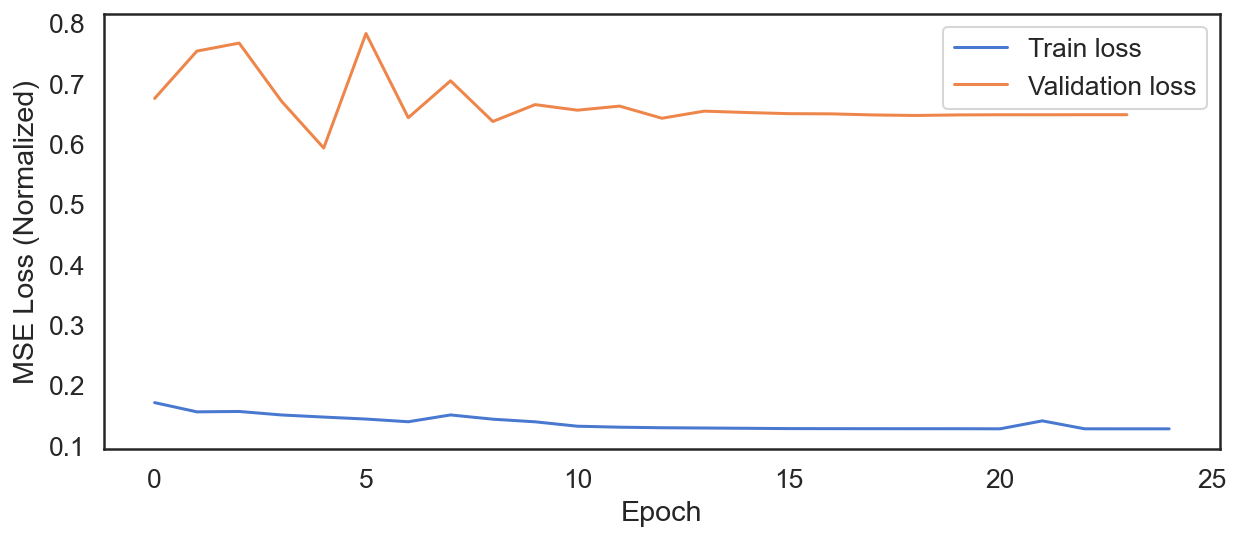

NICOC201M_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------
Train loss: 0.5685888516375449
Val loss: 0.5965263494788599
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.515322749646364
Val loss: 0.6006547479662191
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2
---------
Train loss: 0.49523867529841653
Val loss: 0.5951025124991709
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 3
---------
Train loss: 0.4810802991464075
Val loss: 0.7215719353984037
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4
---------
Train loss: 0.4794404673365365
Val loss: 0.6094667214560994
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5
---------
Train loss: 0.4715270067210746
Val loss: 0.636230018171033
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.4576938409615407
Val loss: 0.6290923261094368
Adjusting learning rate of group 0 to 1.0000e-03.

Epo

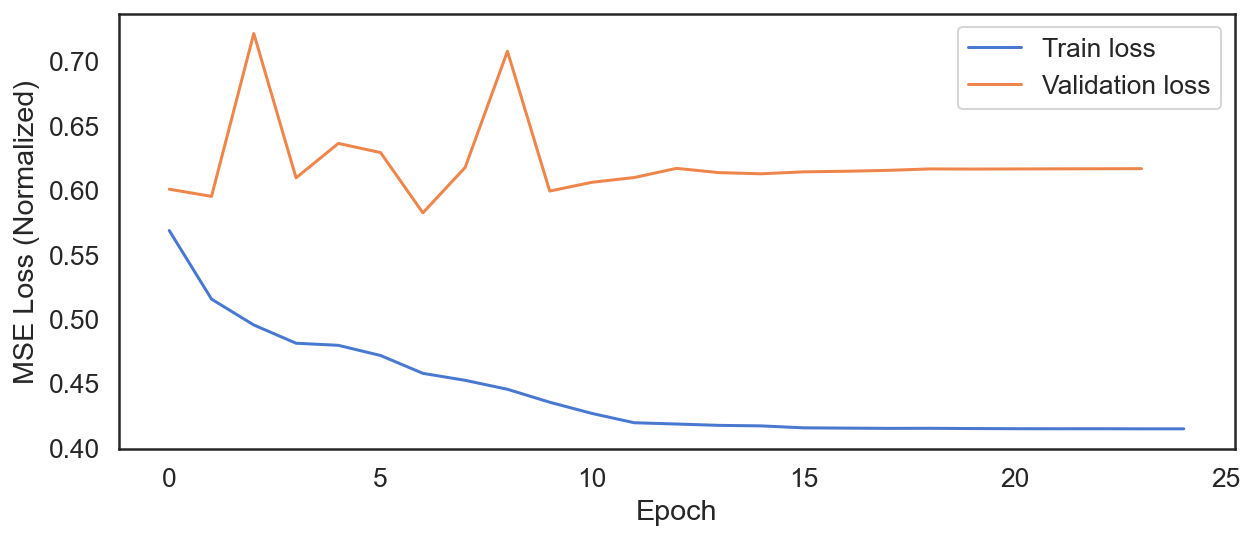

NICOE203_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------
Train loss: 0.1438774658936527
Val loss: 0.02989474654070472
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.11444549132113167
Val loss: 0.026699311411678594
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 2
---------
Train loss: 0.09888673018975754
Val loss: 0.020272861784503465
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 3
---------
Train loss: 0.0948082175304975
Val loss: 0.022294952248707544
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4
---------
Train loss: 0.08024880899070516
Val loss: 0.02056024844848735
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5
---------
Train loss: 0.0764093572635535
Val loss: 0.024154678997526602
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.08081279919343934
Val loss: 0.019569715877649115
Adjusting learning rate of

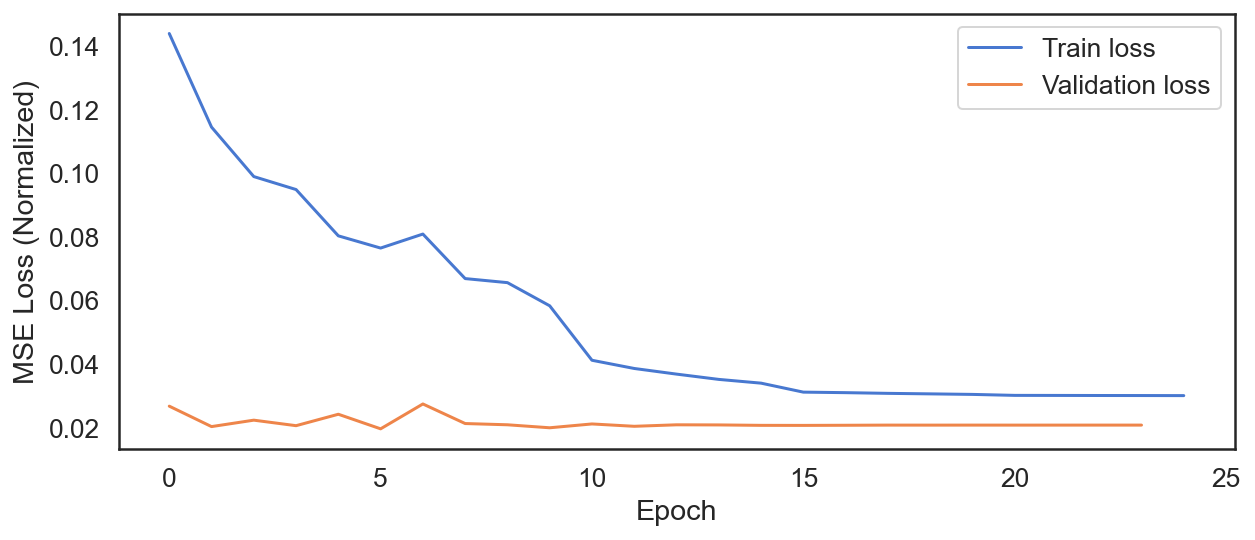

NICOGPS50_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------
Train loss: 0.5554316340269667
Val loss: 0.25653786034197423
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.4287989830301049
Val loss: 0.2543407930232383
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 2
---------
Train loss: 0.39028100114525033
Val loss: 0.24502826796995628
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 3
---------
Train loss: 0.38067719705653996
Val loss: 0.24685244885650842
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4
---------
Train loss: 0.3803985557294963
Val loss: 0.24223913641394795
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 5
---------
Train loss: 0.3729211322678609
Val loss: 0.25222186928665313
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.3713174332829004
Val loss: 0.2377310418841001
Adjusting learning rat

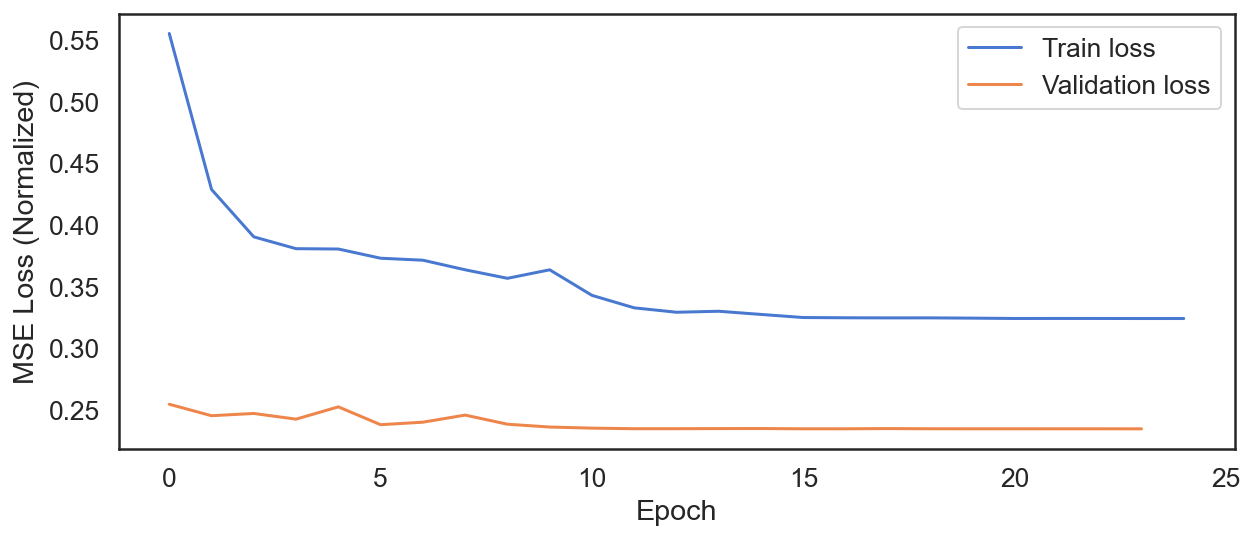

NICOR856_merged.csv
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0
---------
Train loss: 0.46253161297961093
Val loss: 0.31255408706120846
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 1
---------
Train loss: 0.3997726075284578
Val loss: 0.30240692537002634
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 2
---------
Train loss: 0.39446383104989713
Val loss: 0.30847083029343325
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3
---------
Train loss: 0.3880786384979528
Val loss: 0.29550153889647146
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 4
---------
Train loss: 0.38353848500922066
Val loss: 0.29058701459273095
Adjusting learning rate of group 0 to 1.0000e-03.
Model saved

Epoch 5
---------
Train loss: 0.37807657570928765
Val loss: 0.3125785112492496
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6
---------
Train loss: 0.3810156913857499
Val loss: 0.29107130992847474
Adjusting learning r

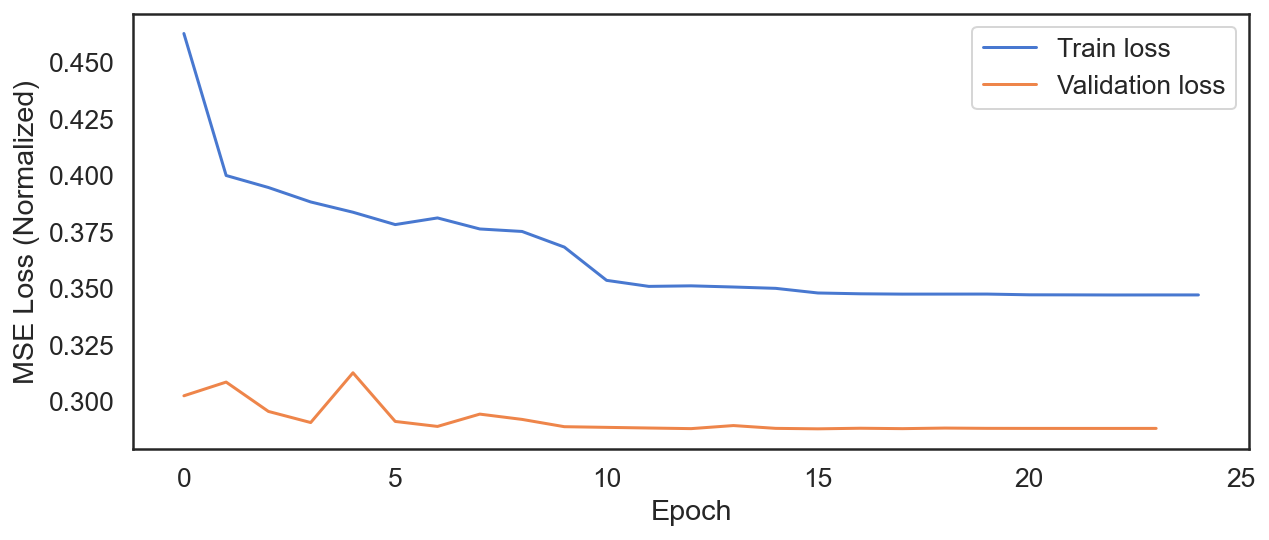

In [3]:
# LSTM training
path_of_the_directory= 'train_hubs'

for filename in os.listdir(path_of_the_directory):
    f = os.path.join(path_of_the_directory,filename)
    if os.path.isfile(f):
        df = pd.read_csv(f)
        print(filename)
        station_name = df['StationID'][0]
        sat_name = df['SatID'][0]
        df['Time'] = pd.to_datetime(df['Time'])
        df.set_index('Time', inplace=True)
        
        feature = 'dTEC'
        forecast_lead = 1 # 15sec intervals, 20 = 5min
        target = f"dTEC_lead{forecast_lead}"
        df[target] = df['dTEC'].shift(-forecast_lead)
        df = df.iloc[:-forecast_lead]
        
        # normailzie on train data
        # Split the data set between training, validation, and test data
        val_start = "2022-12-08"
        val_end = "2023-01-01"
        df_train = df.loc[:val_start].copy()
        df_val = df.loc[val_start:val_end].copy()
        
        # normalize dTEC
        feat_mean = df_train['dTEC'].mean()
        feat_stdev = df_train['dTEC'].std()
        
        df_train['dTEC'] = (df_train['dTEC'] - feat_mean) / feat_stdev
        df_train[target] = (df_train[target] - feat_mean) / feat_stdev
        
        df_val['dTEC'] = (df_val['dTEC'] - feat_mean) / feat_stdev
        df_val[target] = (df_val[target] - feat_mean) / feat_stdev

        # set feature and target variables into strings for sequence
        feature = [str(feature)]
        targetx = [str(target)]

        # Set up data into sequences
        train_dataset = SequenceDataset(
            df_train,
            target=targetx,
            features=feature,
            sequence_length=sequence_length
        )
        val_dataset = SequenceDataset(
            df_val,
            target=targetx,
            features=feature,
            sequence_length=sequence_length
        )

        # convert to torch data
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 
        
        plot_loss = []
        plot_tloss = []
        loss_bookkeeping = np.array([100,100])
        
        # LSTM model set, loss function, Adam optimizer, and learning rate schedule
        model = LSTM_2(num_sensors=1, hidden_units=num_hidden_units).to(device)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = MultiStepLR(optimizer, milestones=[10,15,20], gamma=0.1, verbose=True)

        # iterate 25 times and save best model features into .pth file
        for ix_epoch in range(25):
            print(f"Epoch {ix_epoch}\n---------")
            train_model(train_loader, model, loss_function, optimizer=optimizer)
            val_loss = val_model(val_loader, model, loss_function)
            scheduler.step()

            # If loss reaches new low, save model
            vloss = np.array(val_loss)
            if vloss < loss_bookkeeping.min():
                torch.save(model,'models/best_model_{0}_{1}.pth'.format(station_name, sat_name[0]))
                print('Model saved')
                loss_bookkeeping = np.append(loss_bookkeeping, vloss)
            print()
            
    # plot MSE train / val for each station model
    plt.figure(figsize=(10,4), dpi=72)
    plt.plot(plot_loss, label = 'Train loss')
    plt.plot(plot_tloss[1:], label = 'Validation loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (Normalized)')
    plt.show()